In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import scipy
import sklearn
import statistics

In [39]:
#Load in datasets
wage_data = pd.read_excel('Wages_2013-2020.xlsx')
tables_data = pd.read_excel('Final Tables 2013-2020.xlsx')

In [40]:
# Function that calculates a team's point tally in the form of percent of potential possible points
# This normalizes points tallys, as some leagues play more or less games than others
def grab_percent_of_potential(points, league):
    if league == 'Bundesliga':
        return (points/102)*100
    else:
        return (points/114)*100
    
# Apply to table dataset
tables_data['pct_of_potential_points'] = tables_data.apply(lambda x: grab_percent_of_potential(x.points, x.league), axis=1)

In [41]:
#Reconsile name differences between datasets
tables_data.team = tables_data.team.str.lower().str.replace(' ', '-')
#Teams with different names between datasets that I found
match_names = {'ac-ajaccio': 'ajaccio',
 'as-roma': 'roma',
 'athletic-bilbao': 'athletic-club',
 'borussia-monchengladbach': 'monchengladbach',
 'braunschweig': 'braunschweiger',
 'celta-de-vigo': 'celta-vigo',
 'chievo': 'chievo-verona',
 'deportivo-de-la-coruna': 'deportivo',
 'fc-ingolstadt-04': 'ingolstadt',
 'fc-koln': 'koln',
 'fortuna-dusseldorf': 'dusseldorf',
 'gijon': '',
 'hamburger': 'hamburg',
 'hannover-96': 'hannover',
 'hull': 'hull-city',
 'leverkusen': 'bayer-leverkusen',
 'olympique-lyonnais': 'lyon',
 'paris-saint-germain': 'psg',
 'rb-leipzig': 'leipzig',
 'real-mallorca': 'mallorca',
 'real-valladolid': 'valladolid',
 'sc-paderborn-07': 'paderborn',
 'sv-darmstadt-98': 'darmstadt',
 'schalke': 'schalke-04',
 'vfb-stuttgart': 'stuttgart',
 'verona': 'hellas-verona', 
 'west-brom': 'west-bromwich', 
 'stoke': 'stoke-city', 
 'man-utd': 'manchester-united', 
 'man-city': 'manchester-city'}
#Create reconsiled list and apply to tables data
team_list = []
for team in tables_data.team:
    if team in match_names.keys():
        team_list.append(match_names[team])
    else:
        team_list.append(team)
tables_data.team = team_list 

# Group datasets by team and year, rename columns
team_tables = tables_data[['team', 'year', 'points', 'pct_of_potential_points']].groupby(['team','year']).sum()
wage_data.rename(columns = {'Year': 'year', 'Team': 'team', 'Salary (€/year)': 'salary'}, inplace = True)
team_wages = wage_data[['year', "team", 'salary']].groupby(['team', 'year']).sum()

In [42]:
## Create main dataset - combining table and wages datasets
total = team_tables.merge(team_wages,left_index=True, right_index=True)

# Normalize salary data by league, max value of 101 referring to most expensive team, min value of 1 the least expensive


max_wages = wage_data.groupby(["League", 'team', 'year']).sum().reset_index().groupby(['League', 'year']).max() #Grab most expensive team by league, year
min_wages = wage_data.groupby(["League", 'team', 'year']).sum().reset_index().groupby(['League', 'year']).min() #Grab least expensive team by league, year
def normalized_salary(team, year):
    league = wage_data.loc[(wage_data.team == team)].iloc[0].League 
    league_max_wage = max_wages.loc[(league, year)].salary #Use dataframes created above to lookup most expensive team in the league for a specific team
    league_min_wage = min_wages.loc[(league, year)].salary #Same for least expensive
    team_salary = total.loc[(team, year)].salary #Grab specific team's salary
    norm_value = (((team_salary - league_min_wage) / (league_max_wage - league_min_wage))+.01)*100 # normalized value - on a 1 to 101 scale
    return norm_value

total['norm_salary'] = [normalized_salary(x[0], x[1]) for x in total.index]


In [43]:
total

points  pct_of_potential_points     salary  norm_salary
team          year                                                         
ac-milan      2013      57                50.000000   88132000   101.000000
              2014      52                45.614035   77566000   101.000000
              2015      57                50.000000   73608000    83.865203
              2016      63                55.263158   60973000    50.884438
              2017      64                56.140351  105858000    73.946583
...                    ...                      ...        ...          ...
wolfsburg     2019      49                48.039216   66870000    33.293915
              2020      61                59.803922   57870000    26.379803
wolverhampton 2018      57                50.000000   44614426     4.446349
              2019      59                51.754386   64941483    22.202039
              2020      45                39.473684   61802744    19.131833

[777 rows x 4 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fad031116d0>]],
      dtype=object)

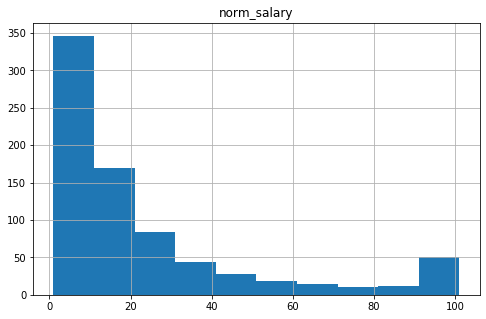

In [44]:
# As we can see in the histogram, the normalized salary data is distributed logarithmically (more or less)
# with most teams in the poorest 10% bin, and the number of teams decreasing as we move to the richer bins
total.hist('norm_salary',figsize=(8,5))

In [45]:
# Create log function of the normalized salary
total['log_norm_salary'] = np.log(total['norm_salary'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fad031d7dd0>]],
      dtype=object)

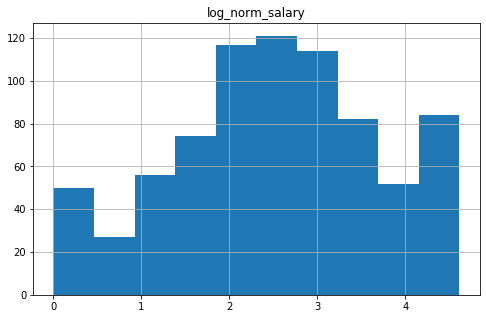

In [46]:
# Now, the logarithmic normalized salary data is more or less normally distributed
total.hist('log_norm_salary',figsize=(8,5))

In [47]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

[ 8.4292024  24.30886239]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


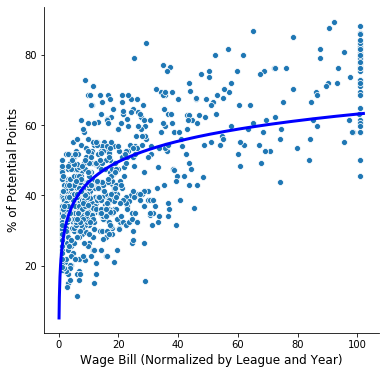

In [60]:
# Visual representation of the logarithmic fit between normalized salary and the percent of potential points
x = total.norm_salary
y = total.pct_of_potential_points
fit = np.polyfit(np.log(x), y, 1)
print(fit)
x = np.linspace(0,102,1000)
y = fit[1] + fit[0]*np.log(x)

fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(data = total, x = 'norm_salary', y = 'pct_of_potential_points')
ax.plot(x,y, 'blue', linewidth=3)
plt.xlabel('Wage Bill (Normalized by League and Year)', size = 12)
plt.ylabel('% of Potential Points', size = 12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('norm_salary_ppp.png')

[0.08429202 0.24308862]


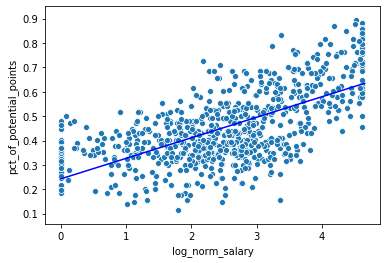

In [12]:
# Visual representation of the linear between logarithmic normalized salary and the percent of potential points
x = total.log_norm_salary
y = total.pct_of_potential_points
fit = np.polyfit(x, y, 1)
print(fit)
x = np.linspace(0,4.65,1000)
y = fit[1] + fit[0]*x
sns.scatterplot(data = total, x = 'log_norm_salary', y = 'pct_of_potential_points')
plt.plot(x,y, 'blue')
plt.show()

In [13]:
#Gini coefficient - measure of inequality that compares current level of inequality to perfectly equality
#Measure the gini coefficient of a team's wage bill

def gini(array):
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = np.trim_zeros(array) #Remove 0's from the array - usually academy players that don't get much playing time
    np.trim_zeros(array)
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

total['gini'] = [gini(np.array(wage_data[(wage_data.team == x[0]) & (wage_data.year == x[1])].salary).astype(float)) for x in total.index] #Grab wage data for each team and year, return gini coefficient and add as a column

print('max gini value:', total.gini.idxmax())
print('gini:', total.gini.max())
print(' ')
print('min gini value:', total.gini.idxmin())
print('gini:', total.gini.min())

max gini value: ('nice', 2018)
gini: 0.6593500234184237
 
min gini value: ('angers', 2016)
gini: 0.1473897207607883


In [14]:
# Galt Score
# Usually the ratio of a company's CEO wage to the median wage of a worker at that company
# In this case, will compare club's top earner to median wage

def galt_score(array):
    array = np.trim_zeros(array)
    top_earner = array.max()
    median_wage = statistics.median(array)
    return top_earner / median_wage

total['galt_score'] = [galt_score(np.array(wage_data[(wage_data.team == x[0]) & (wage_data.year == x[1])].salary).astype(float)) for x in total.index]


In [142]:
print('max Galt Score value:', total.galt_score.idxmax())
print('gini:', total.galt_score.max())
print(' ')
print('min Galt Score value:', total.galt_score.idxmin())
print('gini:', total.galt_score.min())

max Galt Score value: ('monaco', 2013)
gini: 27.96360628618693
 
min Galt Score value: ('angers', 2017)
gini: 1.3946524064171122


In [15]:
#Import statistical modelling packages
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import math

In [16]:
# Train a linear regression model using logarithmic normalized salary as the 
# independant variable, and percent of potential points as the dependant variable 

total['constant'] = 1
X1 = total[['constant','log_norm_salary']]
y1 = total.pct_of_potential_points.values

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=0)

reg_sm1 = sm.OLS(y_train1, X_train1).fit()
reg_sm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     445.3
Date:                Fri, 27 May 2022   Prob (F-statistic):           1.42e-72
Time:                        09:47:57   Log-Likelihood:                 416.02
No. Observations:                 543   AIC:                            -828.0
Df Residuals:                     541   BIC:                            -819.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
constant            0.2441      0.011     21.921      0.000       0.222       0.266
log_norm_salary     0.0838      0.004     21.103      0.000       0.076       0.092
==============================================================================
Omnibus:                        2.114   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.347   Jarque-Bera (JB):                1.920
Skew:                          -0.054   Prob(JB):                        0.383
Kurtosis:                       2.730   Cond. No.                         7.14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

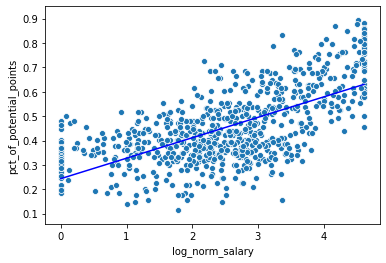

In [17]:
x = np.linspace(total.log_norm_salary.min(),total.log_norm_salary.max(),1000)
y = reg_sm1.params[0] + reg_sm1.params[1]*x
sns.scatterplot(data = total, x = 'log_norm_salary', y = 'pct_of_potential_points')
plt.plot(x,y, 'blue')
plt.show()

In [18]:
#multiple linear regression 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Train a multiple linear regression model using logarithmic normalized salary and the gini 
# coeffient as the independant variables, and percent of potential points as the dependant variable 

X2 = total[['constant','log_norm_salary', 'gini']]
y2 = total.pct_of_potential_points.values

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=0)

reg_sm2 = sm.OLS(y_train2, X_train2).fit()
reg_sm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     226.1
Date:                Fri, 27 May 2022   Prob (F-statistic):           4.57e-72
Time:                        09:47:57   Log-Likelihood:                 418.15
No. Observations:                 543   AIC:                            -830.3
Df Residuals:                     540   BIC:                            -817.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
constant            0.2019      0.023      8.669      0.000       0.156       0.248
log_norm_salary     0.0806      0.004     19.009      0.000       0.072       0.089
gini                0.1203      0.058      2.058      0.040       0.005       0.235
==============================================================================
Omnibus:                        1.668   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.434   Jarque-Bera (JB):                1.640
Skew:                          -0.070   Prob(JB):                        0.441
Kurtosis:                       2.770   Cond. No.                         38.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
# Check for correlation between the independant variables
pd.Series([variance_inflation_factor(X2.values,i) for i in range(X2.shape[1])],index=X2.columns)

constant           24.002134
log_norm_salary     1.151560
gini                1.151560
dtype: float64

In [20]:
# Train a multiple linear regression model using logarithmic normalized salary and the Galt score
# as the independant variables, and percent of potential points as the dependant variable 


X3 = total[['constant','log_norm_salary', 'galt_score']]
y3 = total.pct_of_potential_points.values

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.3, random_state=0)

reg_sm3 = sm.OLS(y_train3, X_train3).fit()
reg_sm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     229.2
Date:                Fri, 27 May 2022   Prob (F-statistic):           8.73e-73
Time:                        09:47:58   Log-Likelihood:                 419.81
No. Observations:                 543   AIC:                            -833.6
Df Residuals:                     540   BIC:                            -820.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
constant            0.2280      0.013     18.218      0.000       0.203       0.253
log_norm_salary     0.0823      0.004     20.648      0.000       0.074       0.090
galt_score          0.0048      0.002      2.753      0.006       0.001       0.008
==============================================================================
Omnibus:                        1.717   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.424   Jarque-Bera (JB):                1.604
Skew:                          -0.039   Prob(JB):                        0.448
Kurtosis:                       2.746   Cond. No.                         14.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
# Check for correlation between the independant variables
pd.Series([variance_inflation_factor(X3.values,i) for i in range(X3.shape[1])],index=X3.columns)

constant           6.968622
log_norm_salary    1.023572
galt_score         1.023572
dtype: float64